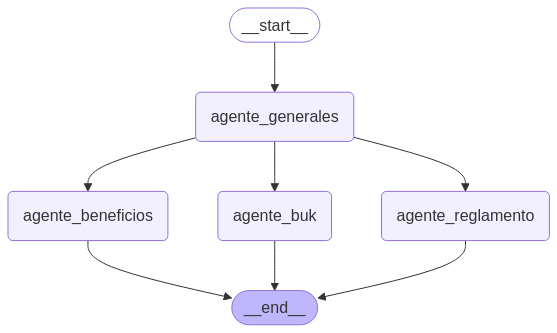

InvalidUpdateError: At key 'pregunta': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE

In [4]:
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_openai import ChatOpenAI
from langchain.tools import Tool
from langchain.agents import create_react_agent
from IPython.display import display, Image

class State(MessagesState):
    pregunta: str

# Agente 1: Beneficios (Consulta en internet)
def agente_beneficios(state: dict):
    """Consulta información en internet sobre beneficios"""
    pregunta = state.get("pregunta", "").lower()
    return {"pregunta": f"Buscando en internet información sobre: {pregunta}"}

# Agente 2: BUK (Consulta de documentos y permisos)
def agente_buk(state: dict):
    """Accede a documentos y permisos en la API de BUK"""
    pregunta = state.get("pregunta", "").lower()
    return {"pregunta": f"Consultando en BUK sobre: {pregunta}"}

# Agente 3: Reglamento Interno
def agente_reglamento(state: dict):
    """Responde preguntas sobre el Reglamento de Higiene y Seguridad"""
    pregunta = state.get("pregunta", "").lower()
    return {"pregunta": f"Buscando en el reglamento interno sobre: {pregunta}"}

# Agente 4: Preguntas Generales
def agente_generales(state: dict):
    """Responde preguntas básicas como fechas de pago y trámites"""
    pregunta = state.get("pregunta", "").lower()
    if "fecha de pago" in pregunta:
        return {"pregunta": "Las fechas de pago de sueldos son el 30 de cada mes"}
    return {"pregunta": "No tengo información sobre esa consulta."}

# Crear el flujo del grafo multiagente
workflow = StateGraph(State)

# Agregar nodos al grafo
workflow.add_node("agente_beneficios", agente_beneficios)
workflow.add_node("agente_buk", agente_buk)
workflow.add_node("agente_reglamento", agente_reglamento)
workflow.add_node("agente_generales", agente_generales)

# Definir flujo de nodos
workflow.add_edge(START, "agente_generales")  # Punto de entrada
workflow.add_edge("agente_generales", "agente_beneficios")
workflow.add_edge("agente_generales", "agente_buk")
workflow.add_edge("agente_generales", "agente_reglamento")
workflow.add_edge("agente_beneficios", END)
workflow.add_edge("agente_buk", END)
workflow.add_edge("agente_reglamento", END)

# Compilar el grafo
graph = workflow.compile()

# Mostrar el grafo en una imagen
display(Image(graph.get_graph().draw_mermaid_png()))

# Ejecutar flujo con prueba inicial
if __name__ == "__main__":
    estado_inicial = {"pregunta": "¿Cuál es la fecha de pago del sueldo?"}
    response = graph.invoke(estado_inicial)
    print(response["pregunta"])